In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def add_bollinger_bands(df: pd.DataFrame, period: int = 20, std_dev: float = 2.0) -> pd.DataFrame:
    """Add Bollinger Bands manually"""
    df = df.copy()
    df['bb_middle'] = df['close'].rolling(window=period).mean()
    bb_std = df['close'].rolling(window=period).std()
    df['bb_upper'] = df['bb_middle'] + (bb_std * std_dev)
    df['bb_lower'] = df['bb_middle'] - (bb_std * std_dev)
    df['bb_percent'] = (df['close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
    return df

def plot_bollinger_bands(df: pd.DataFrame, n_periods: int = 500):
    """Plot price with Bollinger Bands"""
    plot_df = df.tail(n_periods)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), height_ratios=[3, 1])
    
    # Price and bands
    ax1.plot(plot_df.index, plot_df['close'], 'k-', linewidth=1, label='Close')
    ax1.plot(plot_df.index, plot_df['bb_upper'], 'r--', alpha=0.7, label='Upper')
    ax1.plot(plot_df.index, plot_df['bb_middle'], 'b-', alpha=0.7, label='Middle')
    ax1.plot(plot_df.index, plot_df['bb_lower'], 'g--', alpha=0.7, label='Lower')
    ax1.fill_between(plot_df.index, plot_df['bb_upper'], plot_df['bb_lower'], alpha=0.1)
    
    # Mark breakouts
    upper_breaks = plot_df['close'] > plot_df['bb_upper']
    lower_breaks = plot_df['close'] < plot_df['bb_lower']
    ax1.scatter(plot_df.index[upper_breaks], plot_df['close'][upper_breaks], c='red', s=20)
    ax1.scatter(plot_df.index[lower_breaks], plot_df['close'][lower_breaks], c='green', s=20)
    
    ax1.set_title('Bollinger Bands')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # %B indicator
    ax2.plot(plot_df.index, plot_df['bb_percent'], 'purple')
    ax2.axhline(y=1, color='red', linestyle='--', alpha=0.7)
    ax2.axhline(y=0, color='green', linestyle='--', alpha=0.7)
    ax2.set_title('%B Indicator')
    ax2.set_ylabel('%B')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

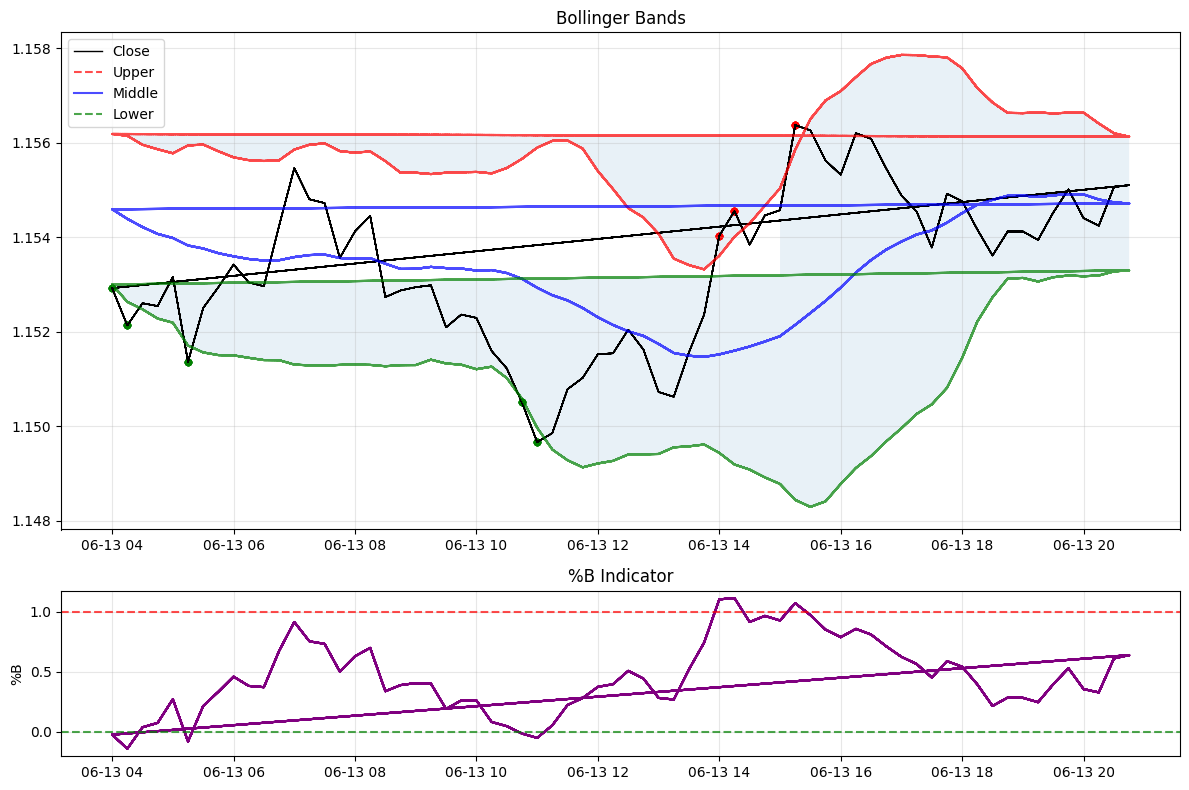

In [3]:
import pandas as pd
df = pd.read_csv('hist_data/EURUSD_15min_data.csv', parse_dates=['dt'])
df = add_bollinger_bands(df)

df.set_index('dt', inplace=True)

plot_bollinger_bands(df)

In [4]:
import pandas as pd
import numpy as np

def add_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    """Add technical indicators for features"""
    df = df.copy()
    
    # Bollinger Bands (already added)
    df = add_bollinger_bands(df)
    
    # RSI
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))
    
    # MACD
    ema12 = df['close'].ewm(span=12).mean()
    ema26 = df['close'].ewm(span=26).mean()
    df['macd'] = ema12 - ema26
    df['macd_signal'] = df['macd'].ewm(span=9).mean()
    
    # Volume indicators (if volume available)
    if 'volume' in df.columns:
        df['volume_sma'] = df['volume'].rolling(20).mean()
        df['volume_ratio'] = df['volume'] / df['volume_sma']
    
    # Price momentum
    df['price_change_1'] = df['close'].pct_change(1)
    df['price_change_5'] = df['close'].pct_change(5)
    df['volatility'] = df['close'].rolling(20).std()
    
    # Time features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    
    return df

def create_ml_dataset(df: pd.DataFrame, pip_threshold: float = 20) -> pd.DataFrame:
    """Create dataset for LightGBM training, including dt_of_break, PnL, and profit_potential.
    SL is triggered intra-bar (high/low). TP (mean reversion) is triggered on close.
    """
    df_with_indicators = add_technical_indicators(df.copy())
    
    # Ensure index is datetime for time features if not already handled
    if not isinstance(df_with_indicators.index, pd.DatetimeIndex):
        print("Warning: DataFrame index is not DatetimeIndex in create_ml_dataset. Time features might be NaN.")

    # Signal is based on the close of the *previous* candle (t-1)
    upper_breaks_signal_candle = (df_with_indicators['close'].shift(1) > df_with_indicators['bb_upper'].shift(1)).fillna(False)
    lower_breaks_signal_candle = (df_with_indicators['close'].shift(1) < df_with_indicators['bb_lower'].shift(1)).fillna(False)
    
    bb_breaks_signal = (upper_breaks_signal_candle | lower_breaks_signal_candle)

    ml_data = []
    loop_indices_iloc = np.where(bb_breaks_signal.to_numpy())[0]

    for row_iloc in loop_indices_iloc:
        if row_iloc == 0: 
            continue

        dt_of_break = df_with_indicators.index[row_iloc - 1] 
        current_candle_series = df_with_indicators.iloc[row_iloc] 
        current_candle_timestamp = current_candle_series.name 

        if pd.isna(current_candle_series['bb_middle']): 
            continue
        
        if row_iloc >= len(df_with_indicators) - 50:
            continue
            
        event_was_upper_break = upper_breaks_signal_candle.iloc[row_iloc]
        event_was_lower_break = lower_breaks_signal_candle.iloc[row_iloc]

        if not (event_was_upper_break or event_was_lower_break):
            continue 
        if event_was_upper_break and event_was_lower_break: 
            continue

        price_at_decision_point = current_candle_series['close'] 
        bb_middle_at_decision_point = current_candle_series['bb_middle'] 

        if pd.isna(bb_middle_at_decision_point) or pd.isna(price_at_decision_point):
            continue
            
        target = np.nan 
        pnl = np.nan
        profit_potential_feature = np.nan # Initialize profit_potential
        outcome_determined = False

        if event_was_upper_break: 
            sl_price = price_at_decision_point + pip_threshold
            tp_price = bb_middle_at_decision_point 
            profit_potential_feature = price_at_decision_point - tp_price # Calculate for upper break
        elif event_was_lower_break: 
            sl_price = price_at_decision_point - pip_threshold
            tp_price = bb_middle_at_decision_point 
            profit_potential_feature = tp_price - price_at_decision_point # Calculate for lower break
        else:
            continue 

        for k in range(1, 50 + 1):
            future_candle_idx = row_iloc + k
            if future_candle_idx >= len(df_with_indicators): 
                break 

            future_candle = df_with_indicators.iloc[future_candle_idx]
            future_high = future_candle['high']
            future_low = future_candle['low']
            future_close = future_candle['close']

            if pd.isna(future_high) or pd.isna(future_low) or pd.isna(future_close): 
                outcome_determined = False 
                break

            if event_was_upper_break: 
                if future_high >= sl_price:
                    target = 0
                    pnl = -pip_threshold
                    outcome_determined = True
                    break 
                if future_close <= tp_price:
                    target = 1
                    pnl = price_at_decision_point - tp_price 
                    outcome_determined = True
                    break
            elif event_was_lower_break: 
                if future_low <= sl_price:
                    target = 0
                    pnl = -pip_threshold
                    outcome_determined = True
                    break
                if future_close >= tp_price:
                    target = 1
                    pnl = tp_price - price_at_decision_point
                    outcome_determined = True
                    break
        
        if not outcome_determined: 
            continue 
        
        hour_val = current_candle_timestamp.hour if isinstance(current_candle_timestamp, pd.Timestamp) else np.nan
        dow_val = current_candle_timestamp.dayofweek if isinstance(current_candle_timestamp, pd.Timestamp) else np.nan
        
        features = {
            'dt_of_break': dt_of_break,
            'target': target,
            'pnl': pnl,
            'profit_potential': profit_potential_feature * 10000 if not pd.isna(profit_potential_feature) else np.nan, # Add new feature, convert to pips
            'break_type': 1 if event_was_upper_break else 0, 
            'bb_percent': current_candle_series.get('bb_percent', np.nan),
            'rsi': current_candle_series.get('rsi', np.nan),
            'macd': current_candle_series.get('macd', np.nan),
            'macd_signal': current_candle_series.get('macd_signal', np.nan),
            'price_change_1': current_candle_series.get('price_change_1', np.nan),
            'price_change_5': current_candle_series.get('price_change_5', np.nan),
            'volatility': current_candle_series.get('volatility', np.nan),
            'hour': hour_val,
            'day_of_week': dow_val,
        }
        
        if 'volume_ratio' in df_with_indicators.columns: 
            features['volume_ratio'] = current_candle_series.get('volume_ratio', np.nan)
        
        ml_data.append(features)
    
    ml_df = pd.DataFrame(ml_data)
    
    ml_df = ml_df.dropna(subset=[col for col in ml_df.columns if col not in ['dt_of_break']]) 
    
    if not ml_df.empty: # Keep this check before attempting conversions and calculations
        ml_df['pnl'] = ml_df['pnl'].astype(float) * 10000  
        ml_df['target'] = ml_df['target'].astype(int) 
        
        print(f"Created {len(ml_df)} training samples after processing and dropna.")
        print(f"Mean reversion rate (target=1): {ml_df['target'].mean():.2%}")
        if 1 in ml_df['target'].unique():
                print(f"Average PnL for reversion (target=1): {ml_df[ml_df['target']==1]['pnl'].mean():.2f} pips")
        if 0 in ml_df['target'].unique():
            print(f"Average PnL for non-reversion (target=0): {ml_df[ml_df['target']==0]['pnl'].mean():.2f} pips")
        print(f"Overall average PnL of identified signals: {ml_df['pnl'].mean():.4f} pips")
    else:
        print("No training samples generated after processing and dropna.")

    return ml_df
# Usage:
# make dt the index
orig_dataset = create_ml_dataset(df, pip_threshold=.0015)


Created 25614 training samples after processing and dropna.
Mean reversion rate (target=1): 72.16%
Average PnL for reversion (target=1): 24.36 pips
Average PnL for non-reversion (target=0): -15.00 pips
Overall average PnL of identified signals: 13.4044 pips



LightGBM Model Evaluation:

Confusion Matrix (LightGBM):


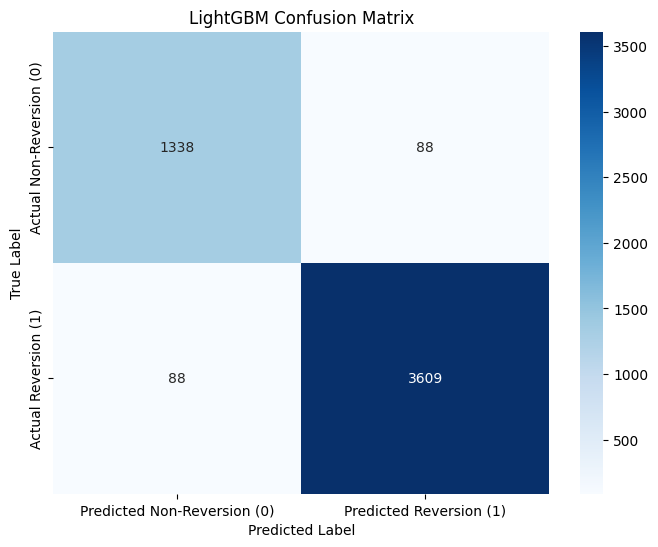

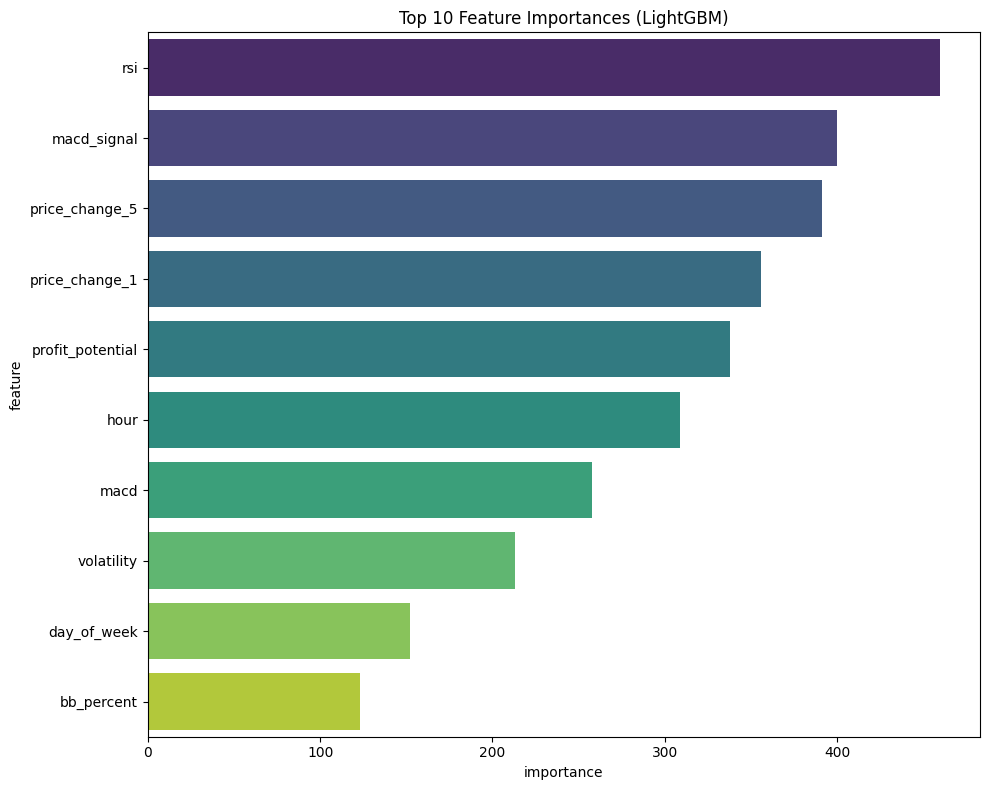


Model PnL Evaluation on Test Set:
Total opportunities in test set: 5123
Number of trades taken by model: 3697
Total PnL from model decisions on test set: 86354.90 pips
Average PnL per trade taken by model: 23.36 pips
Total PnL if all 5123 identified opportunities in test set were taken: 67904.71 pips
Total PnL with perfect foresight (only actual target=1) on test set: 89294.71 pips from 3697 trades


In [5]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns # For a prettier confusion matrix
import matplotlib.pyplot as plt
import pandas as pd # Ensure pandas is imported
import warnings
warnings.filterwarnings("ignore")  # Ignore warnings for cleaner output
# Prepare pnl data for splitting
ml_dataset = orig_dataset.copy()  # Use the dataset created above
pnl_all = ml_dataset['pnl']
del ml_dataset['pnl']  # Remove pnl from the main dataset to avoid leakage
del ml_dataset['dt_of_break']  # Remove dt_of_break as it's not a feature for training

X = ml_dataset.drop(['target'], axis=1)
y = ml_dataset['target']


# Convert all column names in X to strings
X.columns = [str(col) for col in X.columns]

# Convert boolean columns in X to int if any
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)

# Split data into training and testing sets, including pnl
X_train, X_test, y_train, y_test, pnl_train, pnl_test = train_test_split(
    X, y, pnl_all, test_size=0.2, random_state=42, stratify=y if y.nunique() > 1 else None
)

# Initialize and train the LightGBM model
lgbm = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', random_state=42, verbose=-1)

# Fit the model
lgbm.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lgbm = lgbm.predict(X_test)
y_pred_proba_lgbm = lgbm.predict_proba(X_test)[:, 1] # Probabilities for the positive class

# Evaluate the model
print("\nLightGBM Model Evaluation:")

# Confusion Matrix Plot
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Non-Reversion (0)', 'Predicted Reversion (1)'], 
                yticklabels=['Actual Non-Reversion (0)', 'Actual Reversion (1)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

print("\nConfusion Matrix (LightGBM):")
plot_confusion_matrix(y_test, y_pred_lgbm, title='LightGBM Confusion Matrix')

# Feature Importance Plot
def plot_feature_importance(model, X_train_df): # Renamed X_train to X_train_df for clarity
    if hasattr(model, 'feature_importances_'):
        feature_importances = pd.DataFrame({'feature': X_train_df.columns, 'importance': model.feature_importances_})
        feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)
        plt.figure(figsize=(10, 8)) # Adjusted size for better readability
        sns.barplot(x='importance', y='feature', data=feature_importances.head(10), palette="viridis")
        plt.title('Top 10 Feature Importances (LightGBM)')
        plt.tight_layout()
        plt.show()
    else:
        print("Model does not have feature_importances_ attribute.")

plot_feature_importance(lgbm, X_train)

# Calculate PnL on test set based on model predictions
# Trades are taken if model predicts 1 (reversion)
# The PnL for these trades is the actual PnL from pnl_test
# If model predicts 0, trade is not taken, PnL is 0 for that opportunity from model's perspective.

model_decision_pnl_on_test = pnl_test.copy() 
# Where model predicts 0 (no trade), PnL is 0
model_decision_pnl_on_test[y_pred_lgbm == 0] = 0 

total_model_pnl_on_test = model_decision_pnl_on_test.sum()
num_trades_taken_by_model = (y_pred_lgbm == 1).sum()
num_opportunities_in_test = len(y_test)

print(f"\nModel PnL Evaluation on Test Set:")
print(f"Total opportunities in test set: {num_opportunities_in_test}")
print(f"Number of trades taken by model: {num_trades_taken_by_model}")

if num_trades_taken_by_model > 0:
    print(f"Total PnL from model decisions on test set: {total_model_pnl_on_test:.2f} pips")
    print(f"Average PnL per trade taken by model: {total_model_pnl_on_test / num_trades_taken_by_model:.2f} pips")
else:
    print(f"Total PnL from model decisions on test set: 0.00 pips (No trades taken)")

# For comparison: PnL if all identified opportunities in the test set were taken
# This uses the actual outcomes stored in pnl_test for every opportunity
total_pnl_all_opportunities_test = pnl_test.sum()
print(f"Total PnL if all {num_opportunities_in_test} identified opportunities in test set were taken: {total_pnl_all_opportunities_test:.2f} pips")

# For comparison: PnL with perfect foresight on test set opportunities
pnl_perfect_foresight_test = pnl_test[y_test == 1].sum()
num_actual_positive_trades_test = (y_test == 1).sum()
if num_actual_positive_trades_test > 0:
    print(f"Total PnL with perfect foresight (only actual target=1) on test set: {pnl_perfect_foresight_test:.2f} pips from {num_actual_positive_trades_test} trades")
else:
    print(f"Total PnL with perfect foresight (only actual target=1) on test set: 0.00 pips (No actual positive trades)")


In [7]:
# save lgbm model as joblib
import joblib
# Save the trained model to a file
joblib.dump(lgbm, 'lgbm_model.joblib')

# In your model training notebook, after creating X_train:
import json

# Get the list of feature names in the correct order
model_features = X_train.columns.tolist()

# Save the list to a JSON file
with open('model_features.json', 'w') as f:
    json.dump(model_features, f, indent=4)

# Next Steps:
1. Plot some sample trades
1. Add slippage and commission to the backtest
1. test calculated SL
1. Check furthest back date that can get data on
1. Add more stocks
1. Start testing on live data using API